In [2]:
!pip install lightning einops

### ***`Kaggle augmented data`***
---

In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Define basic transformation (no resizing)
from torchvision import transforms

# Define transformation with center cropping
transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),  # Crop to 224x224 from the center
    transforms.ToTensor()
])


# Load the training dataset
train_dir = 'data/Training'
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Check the class-to-index mapping
print(f"Class-to-Index mapping: {train_dataset.class_to_idx}")

# Create a DataLoader for easy batch handling
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Fetch a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Image batch dimensions: {images.size()}")

Class-to-Index mapping: {'bleached_corals': 0, 'healthy_corals': 1}
Image batch dimensions: torch.Size([4, 3, 224, 224])


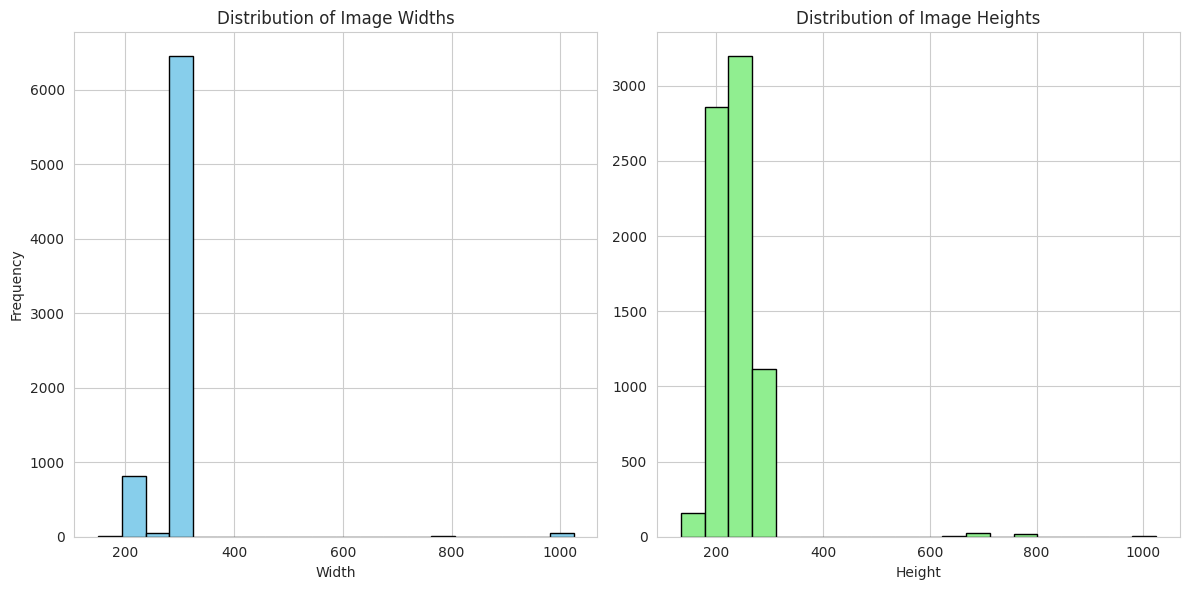

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def collect_image_dimensions(root_dir):
    widths = []
    heights = []

    # Walk through all files in the directory
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif', 'tif', 'tiff')):
                try:
                    image_path = os.path.join(root, file)
                    with Image.open(image_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)

                except Exception as e:
                    print(f"Failed to open or process image {image_path}. Error: {str(e)}")

    return widths, heights

def plot_distributions(widths, heights):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')

    plt.tight_layout()
    plt.show()

# Directory containing the images
image_directory = 'coral_augmented/Training'  # Adjust this path if needed
widths, heights = collect_image_dimensions(image_directory)
plot_distributions(widths, heights)

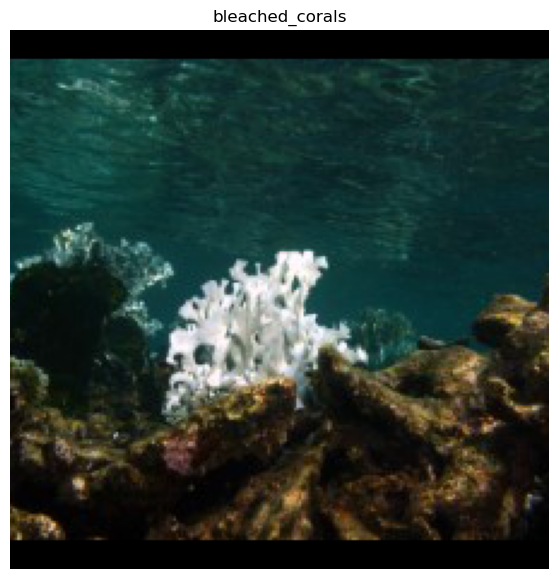

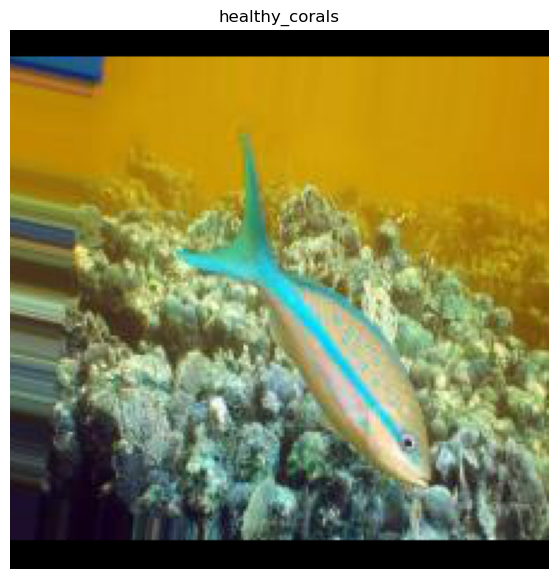

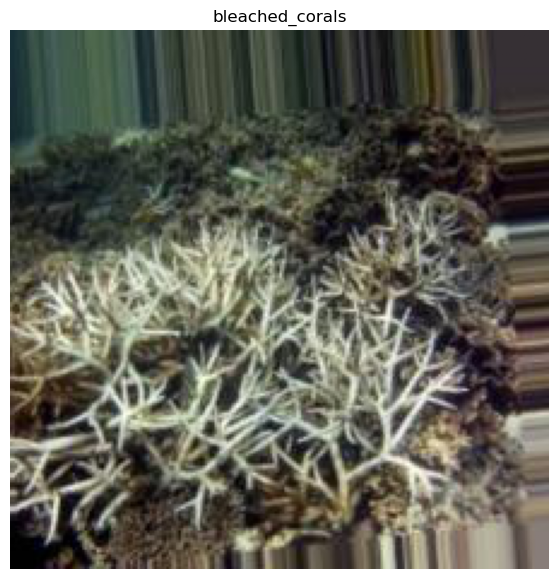

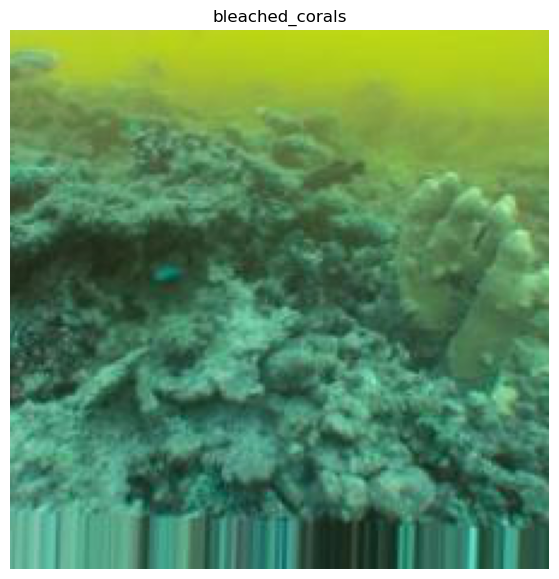

In [21]:
# Function to show images
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the images along with their labels
for idx in range(images.size(0)):
    imshow(images[idx], title=train_dataset.classes[labels[idx]])

### Attempt:
---
---

In [2]:
import os
import torch
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

class CoralDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64, img_size=224, scaler_type='min-max'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.scaler_type = scaler_type
        self.transform = self.get_scaler(scaler_type)

    def get_scaler(self, scaler_type):
        if scaler_type == 'min-max':
            return transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor()  # Converts image to tensor and scales values between 0 and 1
            ])
        else:
            raise ValueError(f"Unknown scaler type: {scaler_type}")

    def prepare_data(self):
        # Download or load your dataset if necessary
        pass

    def setup(self, stage=None):
        # Load data
        full_train_dataset = datasets.ImageFolder(root=os.path.join(self.data_dir, 'Training'), transform=self.transform)
        train_idx, val_idx = train_test_split(
            range(len(full_train_dataset)),
            test_size=0.2,
            shuffle=True,
            stratify=full_train_dataset.targets
        )

        self.train_dataset = Subset(full_train_dataset, train_idx)
        self.val_dataset = Subset(full_train_dataset, val_idx)
        self.test_dataset = datasets.ImageFolder(root=os.path.join(self.data_dir, 'Testing'), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True
        )

In [16]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, F1Score, Precision, Recall
from einops.layers.torch import Rearrange
from torch.optim import Adam

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2

class VisionTransformer(pl.LightningModule):
    def __init__(
        self, img_size=224, patch_size=16, in_channels=3, num_classes=2, embed_size=64, depth=8, heads=4, mlp_dim=128, dropout=0.1
    ):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_size, heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes)
        )
        self.train_accuracy = Accuracy(task='binary')
        self.val_accuracy = Accuracy(task='binary')
        self.test_accuracy = Accuracy(task='binary')
        self.train_f1 = F1Score(task='binary')
        self.val_f1 = F1Score(task='binary')
        self.test_f1 = F1Score(task='binary')
        self.train_precision = Precision(task='binary')
        self.val_precision = Precision(task='binary')
        self.test_precision = Precision(task='binary')
        self.train_recall = Recall(task='binary')
        self.val_recall = Recall(task='binary')
        self.test_recall = Recall(task='binary')
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc_epoch', self.train_accuracy(preds, y), on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc_epoch', self.val_accuracy(preds, y), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc_epoch', self.test_accuracy(preds, y), on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Paths to your dataset
data_dir = 'coral_augmented'

# Initialize the DataModule
data_module = CoralDataModule(data_dir=data_dir, batch_size=32, img_size=224)

# Initialize the Vision Transformer Model
model = VisionTransformer(
            img_size=224, patch_size=8, in_channels=3, num_classes=2, embed_size=64, depth=4, heads=2, mlp_dim=128, dropout=0.1

)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=50,
    precision=16,
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
)

# Train the model
trainer.fit(model, datamodule=data_module)

# Test the model
trainer.test(model, datamodule=data_module)


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type             | Params | Mode 
-----------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding   | 62.7 K | train
1  | transformer_blocks | Sequential       | 133 K  | train
2  | to_cls_token       | Identity         | 0      | train
3  | mlp_head           | Sequential       | 8.7 K  | train
4  | train_accuracy     | BinaryAccuracy   | 0      | train
5  | val_accuracy       | BinaryAccuracy   | 0      | train
6  | test_accuracy      | BinaryAccuracy   | 0      | train
7  | train_f1           | BinaryF1Score    | 0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7778981328010559
     test_loss_epoch        0.7103436589241028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.7103436589241028, 'test_acc_epoch': 0.7778981328010559}]

In [11]:
trainer.test(model, datamodule=data_module)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.7778981328010559
     test_loss_epoch        0.7103436589241028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.7103436589241028, 'test_acc_epoch': 0.7778981328010559}]

#### `Train on original data:`

In [2]:
import os
import torch
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split

class CoralDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64, img_size=224, scaler_type='min-max', test_size=0.2, val_size=0.1, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.val_size = val_size
        self.num_workers = num_workers
        self.transform = self.get_scaler(scaler_type)

    def get_scaler(self, scaler_type):
        if scaler_type == 'min-max':
            return transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor()  # Converts image to tensor and scales values between 0 and 1
            ])
        else:
            raise ValueError(f"Unknown scaler type: {scaler_type}")

    def prepare_data(self):
        # No need to download, just prepare directories or other preprocessing steps if necessary
        pass

    def setup(self, stage=None):
        # Load the full dataset
        full_dataset = datasets.ImageFolder(root=self.data_dir, transform=self.transform)

        # Split the dataset into train, validation, and test
        train_val_idx, test_idx = train_test_split(
            range(len(full_dataset)),
            test_size=self.test_size,
            shuffle=True,
            stratify=full_dataset.targets
        )

        # Further split the train_val set into train and validation sets
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.val_size / (1 - self.test_size),  # Adjust validation size based on remaining data
            shuffle=True,
            stratify=[full_dataset.targets[i] for i in train_val_idx]
        )

        # Create Subset objects for train, val, and test datasets
        self.train_dataset = Subset(full_dataset, train_idx)
        self.val_dataset = Subset(full_dataset, val_idx)
        self.test_dataset = Subset(full_dataset, test_idx)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True
        )

# Example usage
data_module = CoralDataModule(data_dir='coral_original', batch_size=32, img_size=224, test_size=0.2, val_size=0.1)
data_module.setup()


In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

# Limit the process to 90% of the available GPU memory
torch.cuda.set_per_process_memory_fraction(0.9)

# Now, when running your model, it will try to stay within this limit


# Paths to your dataset
data_dir = 'coral_original'

# Initialize the DataModule
data_module = CoralDataModule(data_dir=data_dir, batch_size=32, img_size=224)

# Initialize the Vision Transformer Model
model = VisionTransformer(
            img_size=224, patch_size=8, in_channels=3, num_classes=2, embed_size=64, depth=4, heads=2, mlp_dim=128, dropout=0.1

)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=30,
    precision=16,
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
)

# Train the model
trainer.fit(model, datamodule=data_module)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type             | Params | Mode 
-----------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding   | 62.7 K | train
1  | transformer_blocks | Sequential       | 133 K  | train
2  | to_cls_token       | Identity         | 0      | train
3  | mlp_head           | Sequential       | 8.7 K  | train
4  | train_accuracy     | BinaryAccuracy   | 0      | train
5  | val_accuracy       | BinaryAccuracy   | 0      | train
6  | test_accuracy      | BinaryAccuracy   | 0      | train
7  | train_f1           | BinaryF1Score    | 0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [18]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch          0.800000011920929
     test_loss_epoch        0.4252346158027649
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.4252346158027649, 'test_acc_epoch': 0.800000011920929}]

In [15]:
# After training, print out all the keys in callback_metrics to see what's available
print(trainer.callback_metrics.keys())


dict_keys(['test_loss', 'test_loss_epoch', 'test_acc_epoch'])


In [19]:
def compute_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total


# Assuming you have already trained your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_acc = compute_accuracy(model, data_module.train_dataloader(), device)
val_acc = compute_accuracy(model, data_module.val_dataloader(), device)
test_acc = compute_accuracy(model, data_module.test_dataloader(), device)

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

Final Training Accuracy: 81.09%
Final Validation Accuracy: 84.95%
Final Test Accuracy: 80.00%


### ***`ViT optional embeddings`***
---

In [3]:
# Fourier-based embedding layer
import torch as th
import numpy as np

class NaiveFourierKANLayer(th.nn.Module):
    """ link: https://github.com/GistNoesis/FourierKAN/blob/main/fftKAN.py
    """
    def __init__( self, inputdim, outdim, gridsize, addbias=True, smooth_initialization=False):
        super(NaiveFourierKANLayer,self).__init__()
        self.gridsize = gridsize
        self.addbias  = addbias
        self.inputdim = inputdim
        self.outdim   = outdim

        # With smooth_initialization, fourier coefficients are attenuated by the square of their frequency.
        # This makes KAN's scalar functions smooth at initialization.
        # Without smooth_initialization, high gridsizes will lead to high-frequency scalar functions,
        # with high derivatives and low correlation between similar inputs.
        grid_norm_factor = (th.arange(gridsize) + 1)**2 if smooth_initialization else np.sqrt(gridsize)

        #The normalization has been chosen so that if given inputs where each coordinate is of unit variance,
        #then each coordinates of the output is of unit variance
        #independently of the various sizes
        self.fouriercoeffs = th.nn.Parameter( th.randn(2,outdim,inputdim,gridsize) /
                                                (np.sqrt(inputdim) * grid_norm_factor ) )
        if( self.addbias ):
            self.bias  = th.nn.Parameter( th.zeros(1,outdim))

    #x.shape ( ... , indim )
    #out.shape ( ..., outdim)
    def forward(self,x):
        xshp = x.shape
        outshape = xshp[0:-1]+(self.outdim,)
        x = th.reshape(x,(-1,self.inputdim))
        #Starting at 1 because constant terms are in the bias
        k = th.reshape( th.arange(1,self.gridsize+1,device=x.device),(1,1,1,self.gridsize))
        xrshp = th.reshape(x,(x.shape[0],1,x.shape[1],1) )
        #This should be fused to avoid materializing memory
        c = th.cos( k*xrshp )
        s = th.sin( k*xrshp )
        #We compute the interpolation of the various functions defined by their fourier coefficient for each input coordinates and we sum them
        y =  th.sum( c*self.fouriercoeffs[0:1],(-2,-1))
        y += th.sum( s*self.fouriercoeffs[1:2],(-2,-1))
        if( self.addbias):
            y += self.bias
        #End fuse
        '''
        #You can use einsum instead to reduce memory usage
        #It stills not as good as fully fused but it should help
        #einsum is usually slower though
        c = th.reshape(c,(1,x.shape[0],x.shape[1],self.gridsize))
        s = th.reshape(s,(1,x.shape[0],x.shape[1],self.gridsize))
        y2 = th.einsum( "dbik,djik->bj", th.concat([c,s],axis=0) ,self.fouriercoeffs )
        if( self.addbias):
            y2 += self.bias
        diff = th.sum((y2-y)**2)
        print("diff")
        print(diff) #should be ~0
        '''
        y = th.reshape( y, outshape)
        return y

In [16]:
import torch as th
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall, F1Score
from einops.layers.torch import Rearrange
from einops import repeat
from torch.optim import Adam

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size, embedding_type='conv', fourier_params=None):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        #self.gridsize = gridsize
        self.input_dim = patch_size * patch_size * in_channels

        if embedding_type == 'conv':
            self.proj = nn.Sequential(
                nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
                Rearrange('b e h w -> b (h w) e')  # Explicitly define h and w here
            )
        elif embedding_type == 'linear':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                nn.Linear(self.input_dim, embed_size)
            )
        elif embedding_type == 'fourier':
            if fourier_params == None:
                fourier_params = {}
                
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                NaiveFourierKANLayer(self.input_dim, embed_size, **fourier_params)
            )
        else:
            raise ValueError("Invalid embedding_type. Choose 'conv', 'linear', or 'fourier'")

        self.cls_token = nn.Parameter(th.randn(1, 1, embed_size))
        self.positions = nn.Parameter(th.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = th.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2

class ViT(pl.LightningModule):
    def __init__(
        self, 
        img_size=224, 
        patch_size=4,
        in_channels=1,
        embed_size=64,
        depth=8,
        heads=4,
        mlp_dim=128,
        dropout=0.1, 
        learning_rate=1e-3,  
        embedding_type='conv',
        fourier_params=None
    ):
        super().__init__()
        
        # parameters
        self.learning_rate = learning_rate
        
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, in_channels, embed_size, embedding_type, fourier_params=fourier_params
        )
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_size, heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, 1)  # Change to 1 for binary classification
        )
        
        # Metrics
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        
        self.train_f1 = F1Score(task="binary")
        self.val_f1 = F1Score(task="binary")
        self.test_f1 = F1Score(task="binary")
        
        self.train_precision = Precision(task="binary")
        self.val_precision = Precision(task="binary")
        self.test_precision = Precision(task="binary")
        
        self.train_recall = Recall(task="binary")
        self.val_recall = Recall(task="binary")
        self.test_recall = Recall(task="binary")
        
        self.loss_fn = nn.BCEWithLogitsLoss()
        # manually store losses for plt/sns vizualization
        self.train_losses = []
        self.val_losses   = []

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x).squeeze(-1)  # Ensure the output is the correct shape

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        
        acc = self.train_accuracy(preds, y)
        f1 = self.train_f1(preds, y)
        precision = self.train_precision(preds, y)
        recall = self.train_recall(preds, y)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        
        return {
            'loss':loss,
            'train_f1': f1
        }
    
    def on_train_epoch_end(self):
        # Store the average training loss for this epoch
        avg_train_loss = self.trainer.callback_metrics["train_loss"].item()
        self.train_losses.append(avg_train_loss)
        

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        
        acc = self.val_accuracy(preds, y)
        f1 = self.val_f1(preds, y)
        precision = self.val_precision(preds, y)
        recall = self.val_recall(preds, y)
        
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        
        return {
            'val_loss': loss,
            'val_f1': f1
        }
    
    def on_validation_epoch_end(self):
        # Store the average validation loss for this epoch
        avg_val_loss = self.trainer.callback_metrics["val_loss"].item()
        self.val_losses.append(avg_val_loss)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        
        acc = self.test_accuracy(preds, y)
        f1 = self.test_f1(preds, y)
        precision = self.test_precision(preds, y)
        recall = self.test_recall(preds, y)
        
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Paths to your dataset
data_dir = 'coral_original'

# Initialize the DataModule
data_module = CoralDataModule(data_dir=data_dir, batch_size=12, img_size=224)


# Set Fourier-specific parameters
fourier_params = {
    'gridsize': 32,
    'addbias': True,
    'smooth_initialization': False
}

# Initialize the Vision Transformer Model
model = ViT(
    img_size=224,
    patch_size=8,
    in_channels=3,
    embed_size=32,   #32
    depth=2,         #
    heads=2,
    mlp_dim=64,
    dropout=0.1,
    learning_rate=1e-3,
    embedding_type='fourier',
    fourier_params=fourier_params
)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
)

# Train the model
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type              | Params | Mode 
------------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding    | 418 K  | train
1  | transformer_blocks | Sequential        | 17.1 K | train
2  | to_cls_token       | Identity          | 0      | train
3  | mlp_head           | Sequential        | 97     | train
4  | train_accuracy     | BinaryAccuracy    | 0      | train
5  | val_accuracy       | BinaryAccuracy    | 0      | train
6  | test_accuracy      | BinaryAccuracy    | 0      | train
7  | train_f1           | BinaryF1Score     | 0      | train
8  | val_f1             | BinaryF1Score     | 0      | train
9  | test_f1            | BinaryF1Score     | 0      | train
10 | train_precision    | BinaryPrecision   | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [18]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch          0.837837815284729
      test_f1_epoch         0.7921750545501709
     test_loss_epoch        0.5294004082679749
  test_precision_epoch      0.8958559036254883
    test_recall_epoch       0.7541313171386719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.5294004082679749,
  'test_acc_epoch': 0.837837815284729,
  'test_f1_epoch': 0.7921750545501709,
  'test_precision_epoch': 0.8958559036254883,
  'test_recall_epoch': 0.7541313171386719}]

In [19]:
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).long()  # Apply sigmoid and threshold
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_labels, all_preds


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return acc, f1, precision, recall

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).long()  # Apply sigmoid and threshold
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_labels, all_preds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `model` is your trained model and `data_module` is the data module
model.to(device)

# Train set evaluation
train_labels, train_preds = evaluate_model(model, data_module.train_dataloader(), device)
train_acc, train_f1, train_precision, train_recall = calculate_metrics(train_labels, train_preds)

# Test set evaluation
test_labels, test_preds = evaluate_model(model, data_module.test_dataloader(), device)
test_acc, test_f1, test_precision, test_recall = calculate_metrics(test_labels, test_preds)

# Print out the results
print(f"Train Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Train Accuracy: 0.8636, F1: 0.8417, Precision: 0.9360, Recall: 0.7647
Test Accuracy: 0.8378, F1: 0.8125, Precision: 0.9028, Recall: 0.7386


In [24]:
# Access logged metrics
print(trainer.logged_metrics)
print(trainer.callback_metrics)

{'test_loss_step': tensor(5.9635), 'test_acc_step': tensor(0.), 'test_f1_step': tensor(0.), 'test_precision_step': tensor(0.), 'test_recall_step': tensor(0.), 'test_loss_epoch': tensor(0.5294), 'test_acc_epoch': tensor(0.8378), 'test_f1_epoch': tensor(0.7922), 'test_precision_epoch': tensor(0.8959), 'test_recall_epoch': tensor(0.7541)}
{'test_loss': tensor(0.5294), 'test_loss_epoch': tensor(0.5294), 'test_acc': tensor(0.8378), 'test_acc_epoch': tensor(0.8378), 'test_f1': tensor(0.7922), 'test_f1_epoch': tensor(0.7922), 'test_precision': tensor(0.8959), 'test_precision_epoch': tensor(0.8959), 'test_recall': tensor(0.7541), 'test_recall_epoch': tensor(0.7541)}


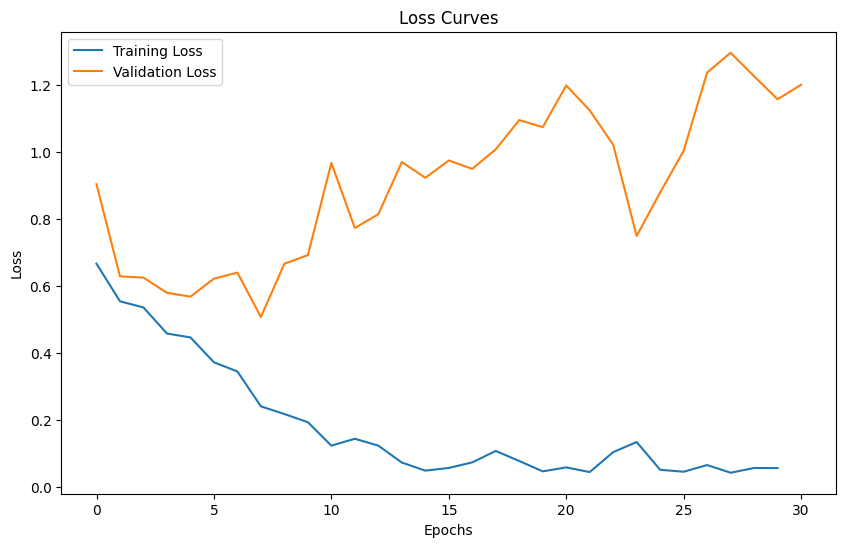

In [ ]:
# Plotting the loss curves
def plot_loss_curves(model):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(model.train_losses)), model.train_losses, label='Training Loss')
    plt.plot(range(len(model.val_losses)), model.val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()


# Plotting the loss curves
plot_loss_curves(model)


# What next?
#=======================================
- 

#### ***Top Candidates***
---
a) MLP
b) Conv
c) Fourier-KAN
    - run#1
        - params:
        - perfromance:
            - 
            - 

### ***`Optuna Studies`***
---

In [5]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [12]:
import optuna
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import PyTorchLightningPruningCallback
from torch.utils.data import DataLoader
from optuna.trial import TrialState
from torchmetrics.classification import F1Score



def objective(trial, embedding_type):
    # Suggest hyperparameters
    patch_size = trial.suggest_int('patch_size', 16, 32, step=4)
    depth      = trial.suggest_int('depth', 1, 6)
    mlp_dim    = trial.suggest_categorical('mlp_dim', [64, 128, 256])
    dropout    = trial.suggest_float('dropout', 0.0, 0.5)
    # Suggest an embed_size that is a multiple of 32 to ensure it's divisible by heads
    embed_size = trial.suggest_int('embed_size', 32, 128, step=32)
    
    # Calculate valid head options
    valid_heads = [h for h in range(2, min(embed_size // 32, 8) + 1) if embed_size % h == 0]
    # If there are no valid head options, return a poor score
    if not valid_heads:
        return float('-inf')
    # Else suggest heads from valid options
    heads = trial.suggest_categorical('heads', valid_heads)
    
    # Set fourier-specific parameters if using fourier embedding
    fourier_params = None
    if embedding_type == 'fourier':
        fourier_params = {
            'gridsize':              trial.suggest_int('gridsize', 4, 64),
            'addbias':               trial.suggest_categorical('addbias', [True, False]),
            'smooth_initialization': trial.suggest_categorical('smooth_initialization', [True, False])
        }
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Initialize the model and avoid trial crashes
    try:
        model = ViT(
            img_size=224,
            patch_size=patch_size,
            in_channels=3,
            embed_size=embed_size,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            embedding_type=embedding_type,
            fourier_params=fourier_params,
            learning_rate = learning_rate
        )
    except AssertionError as e:
        print(f"Trial failed due to: {e}")
        return float('-inf')  # Use neg infinity to penalize the trial


    # Initialize the data module (make sure this is defined)
    data_module = CoralDataModule(data_dir='coral_original', batch_size=16, img_size=224)

    # Initialize trainer with Optuna pruning
    trainer = pl.Trainer(
        max_epochs=50,
        precision="16-mixed",
        devices=1 if torch.cuda.is_available() else 1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        log_every_n_steps=1,  # Log every step
        enable_progress_bar=True,  # Enable progress bar
    )

    # Train the model
    trainer.fit(model, datamodule=data_module)

    # Get the training and validation F1-Scores
    train_f1 = trainer.callback_metrics.get('train_f1').item()
    val_f1 = trainer.callback_metrics.get('val_f1').item()

    # Ensure the performance gap is not greater than 5%
    performance_gap = abs(train_f1 - val_f1)
    if performance_gap > 0.05:
        return 0.0  # Penalize trials with large train-validation performance gap

    return val_f1  # Return the validation F1-Score as the objective

#### ***`a) Conv Embedding`***
---

In [14]:
# Limit the process to 90% of the available GPU memory
#torch.cuda.set_per_process_memory_fraction(0.9)

study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(lambda trial: objective(trial, 'conv'), n_trials=28, show_progress_bar=True, catch=(ValueError,))

[I 2024-08-21 06:53:02,851] A new study created in memory with name: no-name-092dbe01-bfb7-4c3c-84a3-bb52d24a9bf0


  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_40/2960663990.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type              | Params | Mode 
------------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding    | 61.9 K | train
1  | transformer_blocks | Sequential        | 75.6 K | train
2  | to_cls_token       | Identity          | 0      | train
3  | mlp_head           | Sequential        | 193    | train
4  | train_accuracy     | BinaryAccuracy    | 0      | train
5  | val_accuracy       | BinaryAccuracy    | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/tmp/ipykernel_40/2960663990.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type              | Params | Mode 
------------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding    | 84.7 K | train
1  | transformer_blocks | Sequential        | 126 K  | train
2  | to_cls_token       | Identity          | 0      | train
3  | mlp_head           | Sequential        | 193    | train
4  | train_accuracy     | BinaryAccuracy    | 0      | train
5  

[I 2024-08-21 06:54:40,836] Trial 0 finished with value: 0.0 and parameters: {'patch_size': 16, 'depth': 3, 'mlp_dim': 64, 'dropout': 0.13851310151128104, 'embed_size': 64, 'heads': 2, 'learning_rate': 2.8368904792409764e-05}. Best is trial 0 with value: 0.0.
[I 2024-08-21 06:54:40,839] Trial 1 finished with value: -inf and parameters: {'patch_size': 32, 'depth': 5, 'mlp_dim': 128, 'dropout': 0.424266421986375, 'embed_size': 32}. Best is trial 0 with value: 0.0.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/tmp/ipykernel_40/2960663990.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type              | Params | Mode 
------------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding    | 61.9 K | train
1  | transformer_blocks | Sequential        | 167 K  | train
2  | to_cls_token       | Identity          | 0      | train
3  | mlp_head           | Sequential        | 193    | train
4  | train_accuracy     | BinaryAccuracy    | 0      | train
5  

[I 2024-08-21 06:56:34,569] Trial 2 finished with value: 0.0 and parameters: {'patch_size': 20, 'depth': 5, 'mlp_dim': 64, 'dropout': 0.13640440068082438, 'embed_size': 64, 'heads': 2, 'learning_rate': 0.0028786269807233675}. Best is trial 0 with value: 0.0.
[I 2024-08-21 06:56:34,574] Trial 3 finished with value: -inf and parameters: {'patch_size': 20, 'depth': 4, 'mlp_dim': 64, 'dropout': 0.23796900130314236, 'embed_size': 32}. Best is trial 0 with value: 0.0.
[I 2024-08-21 06:56:34,576] Trial 4 finished with value: -inf and parameters: {'patch_size': 32, 'depth': 3, 'mlp_dim': 256, 'dropout': 0.12214703368570001, 'embed_size': 32}. Best is trial 0 with value: 0.0.
[I 2024-08-21 06:56:34,579] Trial 5 finished with value: -inf and parameters: {'patch_size': 20, 'depth': 2, 'mlp_dim': 64, 'dropout': 0.4482374950139747, 'embed_size': 32}. Best is trial 0 with value: 0.0.
[W 2024-08-21 06:56:34,582] Trial 6 failed with parameters: {'patch_size': 20, 'depth': 1, 'mlp_dim': 256, 'dropout':

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


[I 2024-08-21 06:58:29,360] Trial 7 finished with value: 0.0 and parameters: {'patch_size': 16, 'depth': 5, 'mlp_dim': 128, 'dropout': 0.4678513681583264, 'embed_size': 64, 'heads': 2, 'learning_rate': 0.003148023322676027}. Best is trial 0 with value: 0.0.
[W 2024-08-21 06:58:29,365] Trial 8 failed with parameters: {'patch_size': 20, 'depth': 1, 'mlp_dim': 128, 'dropout': 0.4687126751362253, 'embed_size': 96} because of the following error: ValueError('CategoricalDistribution does not support dynamic value space.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_40/4286427003.py", line 8, in <lambda>
    study.optimize(lambda trial: objective(trial, 'conv'), n_trials=28, show_progress_bar=True, catch=(ValueError,))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_40/2960663990.

In [16]:
#print(f"Best trial for {embedding_type} embedding:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

# Save the study for further analysis
#study.trials_dataframe().to_csv(f'{embedding_type}_optuna_study.csv')

  Value: 0.0
  Params: {'patch_size': 16, 'depth': 3, 'mlp_dim': 64, 'dropout': 0.13851310151128104, 'embed_size': 64, 'heads': 2, 'learning_rate': 2.8368904792409764e-05}


#### ***`b) MLP Embedding`***
---

#### ***`c) KAN-Fourier Embedding`***
---

In [30]:
import torch as th
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
from einops.layers.torch import Rearrange
from einops import repeat
from torch.optim import Adam

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size, embedding_type='conv', gridsize=32):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.gridsize = gridsize
        self.input_dim = patch_size * patch_size * in_channels

        if embedding_type == 'conv':
            self.proj = nn.Sequential(
                nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
                Rearrange('b e h w -> b (h w) e')  # Explicitly define h and w here
            )
        elif embedding_type == 'linear':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                nn.Linear(self.input_dim, embed_size)
            )
        elif embedding_type == 'fourier':
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                NaiveFourierKANLayer(self.input_dim, embed_size, gridsize=gridsize)
            )
        else:
            raise ValueError("Invalid embedding_type. Choose 'conv', 'linear', or 'fourier'")

        self.cls_token = nn.Parameter(th.randn(1, 1, embed_size))
        self.positions = nn.Parameter(th.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = th.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2

class ViT(pl.LightningModule):
    def __init__(
        self, 
        img_size=28, 
        patch_size=4,
        in_channels=1,
        embed_size=64,
        depth=8,
        heads=4,
        mlp_dim=128,
        dropout=0.1, 
        embedding_type='conv',
        gridsize=32
    ):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size, embedding_type)
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(embed_size, heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, 1)  # Change to 1 for binary classification
        )
        
        # Update metrics for binary classification
        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()
        self.test_accuracy = BinaryAccuracy()
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        self.train_precision = BinaryPrecision()
        self.val_precision = BinaryPrecision()
        self.test_precision = BinaryPrecision()
        self.train_recall = BinaryRecall()
        self.val_recall = BinaryRecall()
        self.test_recall = BinaryRecall()
        
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_blocks(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x).squeeze(-1)  # Ensure the output is the correct shape

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        acc = self.train_accuracy(preds, y)
        f1 = self.train_f1(preds, y)
        precision = self.train_precision(preds, y)
        recall = self.train_recall(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        acc = self.val_accuracy(preds, y)
        f1 = self.val_f1(preds, y)
        precision = self.val_precision(preds, y)
        recall = self.val_recall(preds, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)  # Convert logits to probabilities
        acc = self.test_accuracy(preds, y)
        f1 = self.test_f1(preds, y)
        precision = self.test_precision(preds, y)
        recall = self.test_recall(preds, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [31]:
# Paths to your dataset
data_dir = 'coral_original'

# Initialize the DataModule
data_module = CoralDataModule(data_dir=data_dir, batch_size=8, img_size=224)

# Initialize the Vision Transformer Model
model = ViT(
    img_size=224,
    patch_size=8,
    in_channels=3,
    embed_size=32,   #32
    depth=2,         #
    heads=2,
    mlp_dim=64,
    dropout=0.1,
    embedding_type='fourier',
    gridsize=8
)



# Set up the trainer
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
)

# Train the model
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type              | Params | Mode 
------------------------------------------------------------------
0  | patch_embedding    | PatchEmbedding    | 418 K  | train
1  | transformer_blocks | Sequential        | 17.1 K | train
2  | to_cls_token       | Identity          | 0      | train
3  | mlp_head           | Sequential        | 97     | train
4  | train_accuracy     | BinaryAccuracy    | 0      | train
5  | val_accuracy       | BinaryAccuracy    | 0      | train
6  | test_accuracy      | BinaryAccuracy    | 0      | train
7  | train_f1           | BinaryF1Score     | 0      | train
8  | val_f1             | BinaryF1Score     | 0      | train
9  | test_f1            | BinaryF1Score     | 0      | train
10 | train_precision    | BinaryPrecision   | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [32]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8864864706993103
      test_f1_epoch         0.8672143220901489
     test_loss_epoch        0.4475778639316559
  test_precision_epoch       0.878146767616272
    test_recall_epoch       0.8968854546546936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.4475778639316559,
  'test_acc_epoch': 0.8864864706993103,
  'test_f1_epoch': 0.8672143220901489,
  'test_precision_epoch': 0.878146767616272,
  'test_recall_epoch': 0.8968854546546936}]

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `model` is your trained model and `data_module` is the data module
model.to(device)

# Train set evaluation
train_labels, train_preds = evaluate_model(model, data_module.train_dataloader(), device)
train_acc, train_f1, train_precision, train_recall = calculate_metrics(train_labels, train_preds)

# Test set evaluation
test_labels, test_preds = evaluate_model(model, data_module.test_dataloader(), device)
test_acc, test_f1, test_precision, test_recall = calculate_metrics(test_labels, test_preds)

# Print out the results
print(f"Train Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

Train Accuracy: 0.9302, F1: 0.9264, Precision: 0.9279, Recall: 0.9248
Test Accuracy: 0.8865, F1: 0.8827, Precision: 0.8681, Recall: 0.8977
